# 加载数据

In [1]:
import pandas as pd

def load_atec_data():
    """
    加载蚂蚁金服数据集
    :return:
    """
    data_train = pd.read_csv('./data/atec_nlp_sim_train.csv', sep='\t')
    data_train.columns = ['index', 'q1', 'q2', 'label']
    data_train_add = pd.read_csv('./data/atec_nlp_sim_train_add.csv', sep='\t')
    data_train_add.columns = ['index', 'q1', 'q2', 'label']
    train = pd.concat([data_train, data_train_add])
    return train


In [2]:
train = load_atec_data()

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102475 entries, 0 to 63129
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   102475 non-null  int64 
 1   q1      102475 non-null  object
 2   q2      102475 non-null  object
 3   label   102475 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [4]:
train.head()

,index,q1,q2,label
0,2,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0
1,3,花呗冻结以后还能开通吗,我的条件可以开通花呗借款吗,0
2,4,如何得知关闭借呗,想永久关闭借呗,0
3,5,花呗扫码付钱,二维码扫描可以用花呗吗,0
4,6,花呗逾期后不能分期吗,我这个 逾期后还完了 最低还款 后 能分期吗,0


In [5]:
train["label"].value_counts()

0    83792
1    18683
Name: label, dtype: int64

# 数据预处理

In [6]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import jieba
from gensim.models import Word2Vec

## 数据分布统计与最佳超参数选择

In [7]:
# 因为数据长度不一，我们根据数据分布选择合适的截断长度
def select_best_length(train,limit_ratio=0.95):
    """
    根据数据集的句子长度，选择最佳的样本max-length
    :param limit_ratio:句子长度覆盖度，默认覆盖95%以上的句子
    :return:
    """
    len_list = []
    max_length = 0
    cover_rate = 0.0
    for q1, q2 in zip(train['q1'], train['q2']):
        len_list.append(len(jieba.lcut(q1)))
        len_list.append(len(jieba.lcut(q2)))
    all_sent = len(len_list)
    sum_length = 0
    len_dict = Counter(len_list).most_common()
    for i in len_dict:
        sum_length += i[1] * i[0]
    average_length = sum_length / all_sent
    for i in len_dict:
        rate = i[1] / all_sent
        cover_rate += rate
        if cover_rate >= limit_ratio: # 这种统计有bug，这个只是找到了第95%的频次数据位置，如果这个频数位置对应的数凑巧很小就gg
            max_length = i[0]
            break
    print('句子平均包含词个数:', average_length)
    print('最长的句子词个数:', max_length)
    return max_length

In [8]:
MAX_LENGTH = select_best_length(train)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.694 seconds.
Prefix dict has been built successfully.


句子平均包含词个数: 9.015403757013905
最长的句子词个数: 17


## 构建数据集
构建一个映射词典，把词映射成id，并把对应的映射词典存储起来

In [9]:
def build_data(train):
    """
    构建数据集
    :return:
    """
    sample_x_left = train.q1.apply(lambda x: jieba.lcut(x)).tolist()
    sample_x_right = train.q2.apply(lambda x: jieba.lcut(x)).tolist()
    # 新加一个unk来处理没有遇到过的词
    vocabs = {'UNK'}
    # 遍历数据构建词典
    for x_left, x_right in zip(sample_x_left, sample_x_right):
        for word in x_left + x_right:
            vocabs.add(word)
    # 构建数据集与词典
    sample_x = [sample_x_left, sample_x_right]
    sample_y = train.label.tolist()
    print('句1样本数量：',len(sample_x_left),'，句2样本数量：', len(sample_x_right))
    datas = [sample_x, sample_y]
    word_dict = {wd: index for index, wd in enumerate(list(vocabs))}
    vocab_path = './model/vocab.txt'
    with open(vocab_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(list(vocabs)))
    return datas, word_dict

In [10]:
datas, word_dict = build_data(train)

句1样本数量： 102475 ，句2样本数量： 102475


## 对数据完成处理得到词id构成的数据

In [11]:
def convert_data(datas, word_dict, MAX_LENGTH):
    """
    将数据转换成keras所能处理的格式
    :return: 
    """
    sample_x = datas[0]
    sample_y = datas[1]
    sample_x_left = sample_x[0]
    sample_x_right = sample_x[1]
    
    # 句1 与 句2
    left_x_train = [[word_dict[word] for word in data] for data in sample_x_left]
    right_x_train = [[word_dict[word] for word in data] for data in sample_x_right]
    
    # 标签
    y_train = [int(i) for i in sample_y]
    
    # 用统计的最佳长度对原始数据进行截断和补齐
    left_x_train = pad_sequences(left_x_train, MAX_LENGTH, padding='pre')
    right_x_train = pad_sequences(right_x_train, MAX_LENGTH, padding='pre')
    y_train = np.expand_dims(np.array(y_train), axis=1)
    return left_x_train, right_x_train, y_train

## 训练word2vec

In [12]:
# 训练300维的词向量
def train_w2v(datas):
    """
    训练词向量
    :return:
    """
    sents = datas[0][0] + datas[0][1]
    model = Word2Vec(sentences=sents, vector_size=300, min_count=1)
    model.wv.save_word2vec_format('./model/token_vec_300.bin', binary=False)

In [13]:
train_w2v(datas)

In [14]:
# 加载预训练的词向量
def load_pretrained_embedding():
    """
    加载预训练的词向量
    :return:
    """
    embedding_file = './model/token_vec_300.bin'
    embeddings_dict = {}
    with open(embedding_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split(' ')
            if len(values) < 100:
                continue
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = coefs
    print('总共有 %s 个词和对应的词向量' % len(embeddings_dict))
    return embeddings_dict

In [15]:
# 构建embedding矩阵
def build_embedding_matrix(word_dict, embedding_dict, VOCAB_SIZE, EMBEDDING_DIM):
    """
    加载词向量矩阵
    :return:
    """
    embedding_matrix = np.zeros((VOCAB_SIZE + 1, EMBEDDING_DIM))
    for word, i in word_dict.items():
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# 模型构建与训练
## 导入工具库

In [16]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Lambda, Bidirectional, Dense

import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 参数设置

In [17]:
# 1个batch的样本量
BATCH_SIZE = 512
# embedding的维度
EMBEDDING_DIM = 300
# 训练迭代轮次
EPOCHS = 20
# 模型存储地址
model_path = './model/tokenvec_bilstm2_siamese_model.h5'

## 数据准备

In [18]:
# 词表大小
VOCAB_SIZE = len(word_dict)
# embedding字典矩阵
embeddings_dict = load_pretrained_embedding()
embedding_matrix = build_embedding_matrix(word_dict, embeddings_dict,
                                          VOCAB_SIZE, EMBEDDING_DIM)
# 构建数据
left_x_train, right_x_train, y_train = convert_data(datas, word_dict, MAX_LENGTH)

总共有 13701 个词和对应的词向量


## 构建相似度计算模块

In [19]:
# 计算相似度
def exponent_neg_manhattan_distance(sent_left, sent_right):
    '''基于曼哈顿空间距离计算两个字符串语义空间表示相似度计算'''
    return tf.exp(-tf.math.reduce_sum(tf.abs(sent_left - sent_right), axis=1, keepdims=True))


## 构建共享的特征抽取网络

In [20]:
def create_base_network(input_shape):
    '''搭建编码层网络,用于权重共享'''
    input = Input(shape=input_shape)
    lstm = Bidirectional(LSTM(128))(input)
    output = Dense(16)(lstm)
    # output = Dropout(0.5)(output)
    return Model(input, output)

In [21]:
# 有一个小的冲突，numpy的升级可能和tensorflow有冲突，这里降级到1.19.5的numpy版本
#!pip3 install numpy==1.19.5 --user

## 构建完整网络

In [22]:
def bilstm_siamese_model():
    '''搭建网络'''
    # 词嵌入层，用预训练的词向量
    embedding_layer = Embedding(VOCAB_SIZE + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_LENGTH,
                                trainable=False,
                                mask_zero=True)
    # 左右侧的输入
    left_input = Input(shape=(MAX_LENGTH,), dtype='float32', name="left_x")
    right_input = Input(shape=(MAX_LENGTH,), dtype='float32', name='right_x')
    
    # 使用共享的embedding映射对左右句子进行编码
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)
    
    # 构建共享的LSTM语义抽取组件
    shared_lstm = create_base_network(input_shape=(MAX_LENGTH, EMBEDDING_DIM))
    left_output = shared_lstm(encoded_left)
    right_output = shared_lstm(encoded_right)
    
    # 计算语义相似度
    distance = Lambda(lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                      output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
    
    
    # 构建模型
    model = Model([left_input, right_input], distance)
    
    # 定义损失函数与优化器
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # 输出模型信息
    model.summary()
    return model

## 模型训练

In [23]:
from tensorflow.keras.utils import plot_model

def train_model():
    '''训练模型'''
    model = bilstm_siamese_model()
    plot_model(model, show_shapes=True, to_file='./model/model.png')
    history = model.fit(
        x=[left_x_train, right_x_train],
        y=y_train,
        validation_split=0.2,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
    )
    model.save(model_path)
    return model, history

In [24]:
model, history = train_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_x (InputLayer)            [(None, 17)]         0           []                               
                                                                                                  
 right_x (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 300)      4110900     ['left_x[0][0]',                 
                                                                  'right_x[0][0]']                
                                                                                                  
 model (Functional)             (None, 16)           443408      ['embedding[0][0]',        

## 绘制模型训练中间信息

In [25]:
def draw_train(history):
    '''绘制训练曲线'''
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.savefig("model/result.png")
    plt.show()

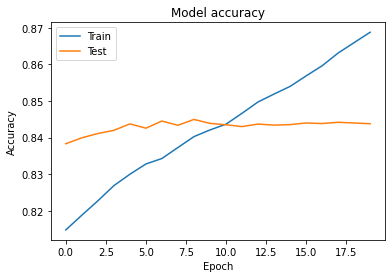

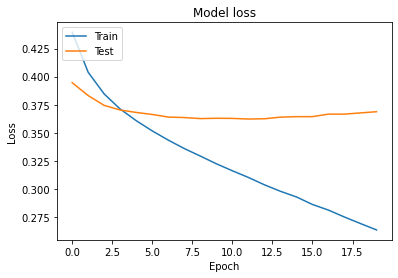

In [26]:
draw_train(history)